In [23]:
from keras.datasets import boston_housing
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.models import *
import numpy as np

In [32]:
(train_x, train_y), (test_x, test_y) = boston_housing.load_data()
sc = StandardScaler()

train_x = sc.fit_transform(train_x)
test_x = sc.fit_transform(test_x)
print(train_x[0])
print(train_y[0])

[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]
15.2


In [34]:
model = Sequential()#先建立一个顺序模型
model.add(Dense(256, activation='relu', input_shape=(13,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1)) #因为我们是预测房价，不是分类，所以最后一层可以不用激活函数

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               3584      
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22145 (86.50 KB)
Trainable params: 22145 (86.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [35]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(train_x,train_y,epochs=500,batch_size=64,validation_data=(test_x, test_y))

Epoch 1/500
7/7 [==============================] - 1s 32ms/step - loss: 575.2314 - mae: 22.1523 - val_loss: 575.4263 - val_mae: 22.1762
Epoch 2/500
7/7 [==============================] - 0s 9ms/step - loss: 525.5347 - mae: 21.0043 - val_loss: 515.8676 - val_mae: 20.7667
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 458.2901 - mae: 19.3014 - val_loss: 424.3193 - val_mae: 18.4759
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 357.2832 - mae: 16.6470 - val_loss: 300.4156 - val_mae: 15.3819
Epoch 5/500
7/7 [==============================] - 0s 6ms/step - loss: 231.4543 - mae: 12.9770 - val_loss: 164.3889 - val_mae: 11.2187
Epoch 6/500
7/7 [==============================] - 0s 7ms/step - loss: 117.8179 - mae: 8.8221 - val_loss: 80.3030 - val_mae: 7.3946
Epoch 7/500
7/7 [==============================] - 0s 9ms/step - loss: 75.8902 - mae: 6.8251 - val_loss: 68.1673 - val_mae: 6.4840
Epoch 8/500
7/7 [==============================] - 0s 6ms/st

4/4 [==============================] - 0s 4ms/step


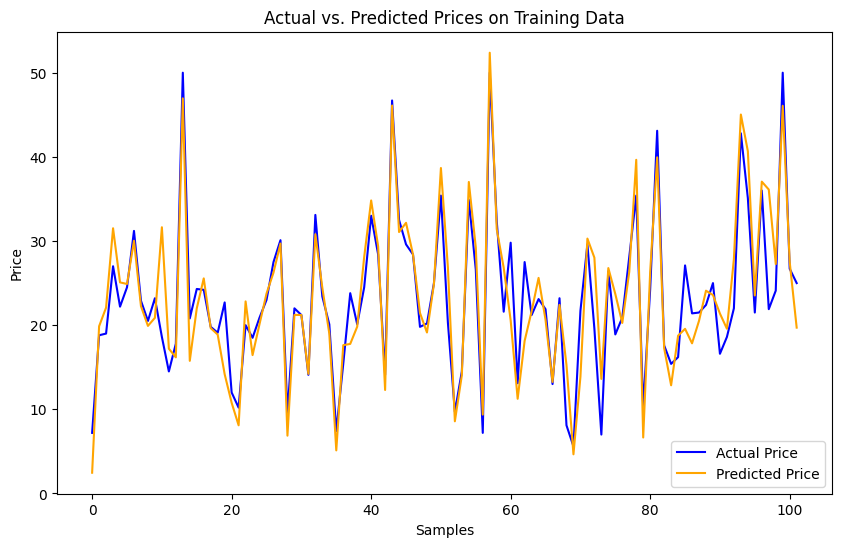

In [42]:
import matplotlib.pyplot as plt

# 对训练集进行预测
test_predictions = model.predict(test_x).flatten()

# 绘制预测值和实际值的曲线关系图
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual Price', color='blue')
plt.plot(test_predictions, label='Predicted Price', color='orange')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices on Training Data')
plt.legend()
plt.show()
